In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import estimation_functions as ef

In [2]:
# Define default plot parameters
# Set the default font family
plt.rcParams['font.family'] = 'Helvetica'

# Set font size for tick labels
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

# Set font size for legend
plt.rcParams['legend.fontsize'] = 24

# Set font size for guide (axis labels, titles, etc.)
plt.rcParams['axes.labelsize'] = 24

#Define the colors to match Julia plots
color_blue = '#75BDF7'
color_orange = '#E57650'

In [3]:
#set data folder path, this is on the same level of the current folder
data_folder = '../Data/'
result_folder = '../Figures/'
df_import = pd.read_csv(data_folder + '/data.csv',index_col=0,parse_dates=True)

In [38]:
# Functions 
def get_data_deviation(df, window_size):
       window_size = window_size #days
       df['fundamental'] = df['BTC'].rolling(window_size).mean()
       df['BTC_dev'] = (df['BTC'] - df['fundamental'])
       df['BITSI'] = df['compound']
       return df

# Create the estimation data set
def create_estimation_df(df, a = 1.0):
    df_estimation = pd.DataFrame()
    #Divide each variable by 10000 to make the coefficients of the same order of magnitude
    df_estimation['fundamental'] = df['fundamental']
    df_estimation['y'] = df['BTC_dev']/df['fundamental']
    df_estimation['x0'] = (df['BTC_dev'].shift(1))/df['fundamental']
    df_estimation['x1'] = (df['BTC_dev'].shift(2))
    df_estimation['x2'] = (df['BTC_dev'].shift(3))
    df_estimation['x3'] = ((df['BITSI']).shift(0))/df['fundamental']
    df_estimation['x4'] = ((df['BITSI']).shift(1))
    df_estimation['x5'] = ((df['BITSI']).shift(2))
    df_estimation['x6'] = (df['Rf'])
    df_estimation['x7'] = (df['Rf'].shift(1))
    df_estimation['x8'] = (df['Rf'].shift(2))
    df_estimation['x9'] = 1
    df_estimation['x10'] = 1 #copying it to use it in the profits
    df_estimation['x11'] =(df['fundamental'].shift(2))**2 #copying it to use it in the profits
    df_estimation['x12'] = (df['BTC_dev'].shift(1)) #copying it to use it in the profits
    df_estimation['y_ML'] = df['BTC_dev'].shift(-1)/df['fundamental']
    df_estimation = df_estimation.dropna()
    return df_estimation


In [39]:
# Transform the BTC data in deviation from a moving average

# Define a windows list, integers from 1 to 30
windows = list(range(1,99))
betas = []
betas_std = []
bees = []
bees_std = []
gees = []
gees_std = []
r_twos = []
F_tests = []
model = ef.trend_follower_plus_bias

for window in windows:
    df_raw = get_data_deviation(df_import, window)
    df = create_estimation_df(df_raw)
    #Define x_data and y_data
    x_data = [df['x0'], df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6'], df['x7'], df['x8'], df['x9'], df['x10'], df['x11'], df['x12']]
    y_data = df['y']

    # Estimate the parameters
    popt_1, pcov_1 = ef.estimate_params(model, x_data, y_data, bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf]))
    residuals_1, ssres_1, adj_r2_1 = ef.compute_r2_and_residuals(model, popt_1, x_data, y_data)
    # Compute ssr for restricted model
    RSS_R = ef.fit_AR_model(df)
    # Compute F-test
    F_1, p_1 = ef.f_test_lag_and_bitsi(ssres_1, RSS_R, len(y_data))
    # Store the results
    betas.append(popt_1[2])
    betas_std.append(np.sqrt(np.diag(pcov_1))[2])
    bees.append(popt_1[1])
    bees_std.append(np.sqrt(np.diag(pcov_1))[1])
    gees.append(popt_1[0])
    gees_std.append(np.sqrt(np.diag(pcov_1))[0])
    r_twos.append(adj_r2_1)
    F_tests.append(p_1)



/Users/tommasodifrancesco/Desktop/Repo/Estimation/estimation_functions.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ssres / sstot)


F-stat:,  -1142.0 p-value:  1.0
F-stat:,  0.05363450490587401 p-value:  0.816897032972546
F-stat:,  0.05360067307436301 p-value:  0.816953802145844
F-stat:,  0.052435590849530436 p-value:  0.8189192040787099
F-stat:,  0.053626468804178276 p-value:  0.8169106164906719
F-stat:,  0.05311430555815356 p-value:  0.8177715971926806
F-stat:,  0.05347303065384968 p-value:  0.8171681624223118
F-stat:,  0.05230187548344711 p-value:  0.8191463763493693
F-stat:,  0.05203864476285439 p-value:  0.8195942305184222
F-stat:,  0.051515820520802 p-value:  0.8204872617971092
F-stat:,  0.05197163557328485 p-value:  0.8197084918143743
F-stat:,  0.051386179771313566 p-value:  0.820709499741839
F-stat:,  0.0506916225462659 p-value:  0.8219048484455596
F-stat:,  0.050656354167381845 p-value:  0.8219658092328928
F-stat:,  0.051084739855177266 p-value:  0.8212273281360509
F-stat:,  0.05082999579390664 p-value:  0.8216661374009424
F-stat:,  0.050697888771313045 p-value:  0.8218941707229406
F-stat:,  0.050802373186

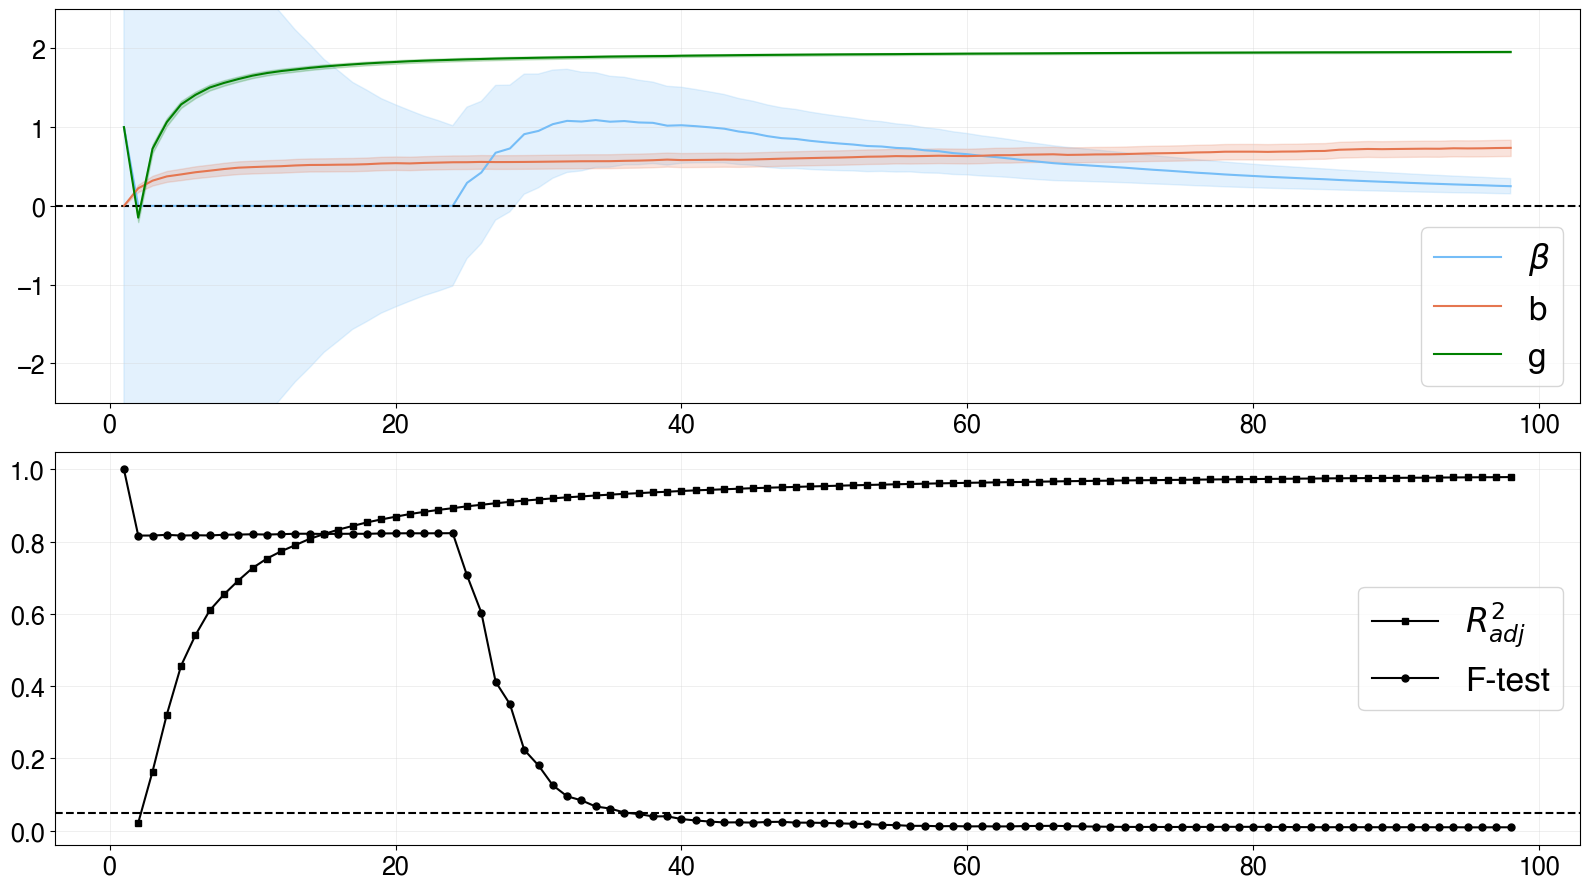

In [40]:
# Plot the results
fig, axs = plt.subplots(2,1, figsize=(16, 9))
#make sure the label is beta in latex
axs[0].plot(windows, betas, color=color_blue, label=r'$\beta$')
axs[0].fill_between(windows, np.array(betas) - np.array(betas_std), np.array(betas) + np.array(betas_std), color=color_blue, alpha=0.2)
axs[0].axhline(y=0, color='black', linestyle='--')
axs[0].plot(windows, bees, color=color_orange, label='b')
axs[0].fill_between(windows, np.array(bees) - np.array(bees_std), np.array(bees) + np.array(bees_std), color=color_orange, alpha=0.2)
axs[0].plot(windows, gees, color='green', label='g')
axs[0].fill_between(windows, np.array(gees) - np.array(gees_std), np.array(gees) + np.array(gees_std), color='green', alpha=0.2)
axs[0].set_ylim(-2.5, 2.5)
# make marker square
axs[1].plot(windows, r_twos, color='black', label=r'$R^2_{adj}$', marker='s', markersize=5)
axs[1].plot(windows, F_tests, color='black', label='F-test', marker = 'o', markersize=5)
axs[0].grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)
axs[1].grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)
#add line for 0.01 significance level
axs[1].axhline(y=0.05, color='black', linestyle='--')
#set the legend in the lower right corner
axs[0].legend(loc='lower right')
axs[1].legend()
fig.tight_layout()
plt.show()

# Save the plot
fig.savefig(result_folder + '/window_length.png', dpi=300, bbox_inches='tight')
